
# 🍱 Ground-Truth Generator for DoorDash Assortment Optimization

We have a known list of restaurants. Our previous notebook already provides 100 real Berkeley restaurants with features:
- restaurant_id
- name
- cuisine
- price_level ∈ {1,2,3}
- rating_5star ∈ [3,5]
- x, y ∈ [0,10] (normalized coordinates)

This part of the pipeline remains unchanged.
This notebook builds the **ground-truth consumer transaction dataset** following Rajan Udwani’s recommendations:

- 10 deterministic customer profiles  
- Each profile has its own β vector  
- Each customer assigned to exactly one profile  
- Each customer has their own cuisine ranking + location + price tolerance (random)
- Each transaction:  
  - Platform presents an assortment of 5 restaurants  
  - Customer chooses the highest-utility restaurant in the 5  
- This creates dataset of (S_t, chosen_t)


We begin with a realistic fixed set of ~100 Berkeley restaurants (with cuisine, price tier, grid-coordinates, and ratings). Then we generate **synthetic customers** who each have (i) a random location, (ii) a budget/price-tolerance, (iii) a random cuisine ranking, and (iv) a delivery-time sensitivity. We map each user into one of **10 interpretable customer profiles**, where a profile encodes *how the user trades off cuisine match, price penalty, ratings, and ETA*. Each profile has a consistent β-vector (taste weights), meaning users within the same segment behave similarly but not identically — they still have different cuisine preference, coordinates, and offer sets. Using these preferences, we simulate a **ranked-choice model (RCM) ground truth**: for every user, we randomly draw an offer set (5 restaurants), compute utilities using the profile-specific β’s, then record the **actual chosen restaurant** (highest utility). This produces the exact form of ground-truth transaction data that emphasized:
[
(s_i,, t_i) = \text{(offer set, chosen restaurant)}
]
for each user. The final dataset correctly includes all necessary fields: user features, profile assignment, offer set IDs and names, chosen restaurant, and the full underlying restaurant catalog. This dataset is now perfectly suitable for:
(1) training ML models (probabilistic choice estimators),
(2) estimating a featurized MNL model, and
(3) computing evaluation metrics (CTR, expected revenue) **under the true ground-truth utilities**.


In [1]:
import numpy as np
import pandas as pd
import itertools
from tqdm import tqdm
np.random.seed(42)
pd.set_option("display.max_columns", None)
pd.set_option("display.width", None)


# 1. Load Restaurants Dataset

Assumptions:


In [3]:
import numpy as np
import pandas as pd
import ast

# Load your existing datasets
users = pd.read_csv("users.csv")
restaurants = pd.read_csv("berkeley_real_restaurants_100.csv")
restaurants.head()

print("Users:", users.shape)
print("Restaurants:", restaurants.shape)

FileNotFoundError: [Errno 2] No such file or directory: 'users.csv'

## Defining 10 customer profiles

Each β vector corresponds to features:

1. β₀ (intercept)

2. β_cuisine

3. β_price

4. β_rating

5. β_eta

Every user in profile p must use the exact same β vector for their utility calculation.That is the whole point of profile-based ground truth: Profiles define behavioral types. Every user of that behavioral type shares the same decision rule (same β’s)

Users differ only in:

- their exact ranked cuisine list
- their location (x, y)
- their price tolerance
- their accessible restaurants

Cuisine type preferences are NOT encoded in the profile — each user still has their own random cuisine ranking.

This avoids contradictions and gives realistic segmentation.

So in final groundtruth:

Utility = profile_betas × (user-restaurant feature vector)

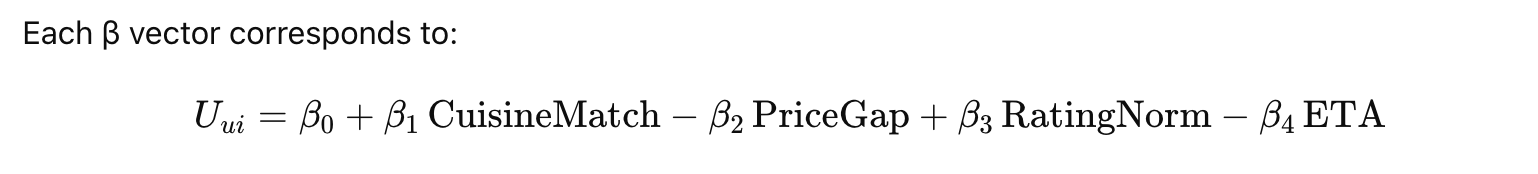

In [ ]:
profiles = {
    1: {"name": "Cuisine-Focused Foodie",
        "description": "Strongly prefers restaurants that match personal cuisine tastes.",
        "beta": [0.0, 2.5, 0.7, 0.8, 0.7]},

    2: {"name": "Budget Shopper",
        "description": "Highly price sensitive; dislikes expensive restaurants.",
        "beta": [0.0, 1.0, 2.2, 0.4, 0.6]},

    3: {"name": "Rating Snob",
        "description": "Cares mostly about high ratings; price and speed are secondary.",
        "beta": [0.0, 1.0, 0.8, 2.8, 0.5]},

    4: {"name": "Speed-Obsessed",
        "description": "ETA is the dominant factor; cuisine type matters less.",
        "beta": [0.0, 0.9, 0.7, 0.7, 2.5]},

    5: {"name": "Quality-Driven Healthy Eater",
        "description": "Values high-quality and well-rated restaurants.",
        "beta": [0.0, 1.3, 1.0, 2.1, 0.7]},

    6: {"name": "Balanced Generalist",
        "description": "Moderate preferences across all features.",
        "beta": [0.0, 1.5, 1.5, 1.5, 1.5]},

    7: {"name": "Curious Food Explorer",
        "description": "Likes variety and experimentation; price-insensitive.",
        "beta": [0.0, 1.8, 0.3, 1.2, 0.9]},

    8: {"name": "Slow but Cheap",
        "description": "Willing to wait longer if food is inexpensive.",
        "beta": [0.0, 1.2, 1.9, 0.9, 0.3]},

    9: {"name": "Convenience Seeker",
        "description": "Wants options that balance rating with quick delivery.",
        "beta": [0.0, 1.0, 1.0, 0.8, 1.8]},

    10: {"name": "Rating + Speed Hybrid",
         "description": "Strongly cares about both high ratings and quick delivery.",
         "beta": [0.0, 1.2, 0.8, 2.0, 1.7]},
}

profiles

# 3. Generate Users
Each user:
- assigned a profile (uniformly)
- has a unique ranked list of cuisines (random)
- has location (x, y) on 0–10 grid
- has price tolerance (1, 2, 3)


In [ ]:
pd.set_option("display.max_columns", None)
pd.set_option("display.width", None)

def generate_users(n=200):
    cuisines = restaurants["cuisine"].unique().tolist()
    users = []

    for u in range(n):
        ranked = list(np.random.permutation(cuisines))
        users.append({
            "user_id": u,
            "profile": np.random.choice(range(1,11)),
            "profile_name": None,  # fill in below
            "profile_description": None,
            "x": np.random.uniform(0,10),
            "y": np.random.uniform(0,10),
            "price_tolerance": np.random.choice([1,2,3]),
            "cuisine_rank": {c: i+1 for i,c in enumerate(ranked)}
        })
    df = pd.DataFrame(users)
    df["profile_name"] = df["profile"].apply(lambda p: profiles[p]["name"])
    df["profile_description"] = df["profile"].apply(lambda p: profiles[p]["description"])
    return df

users = generate_users(200)
users.head()

# 4. Utility Components: CuisineMatch, PricePenalty, ETA, RatingNorm


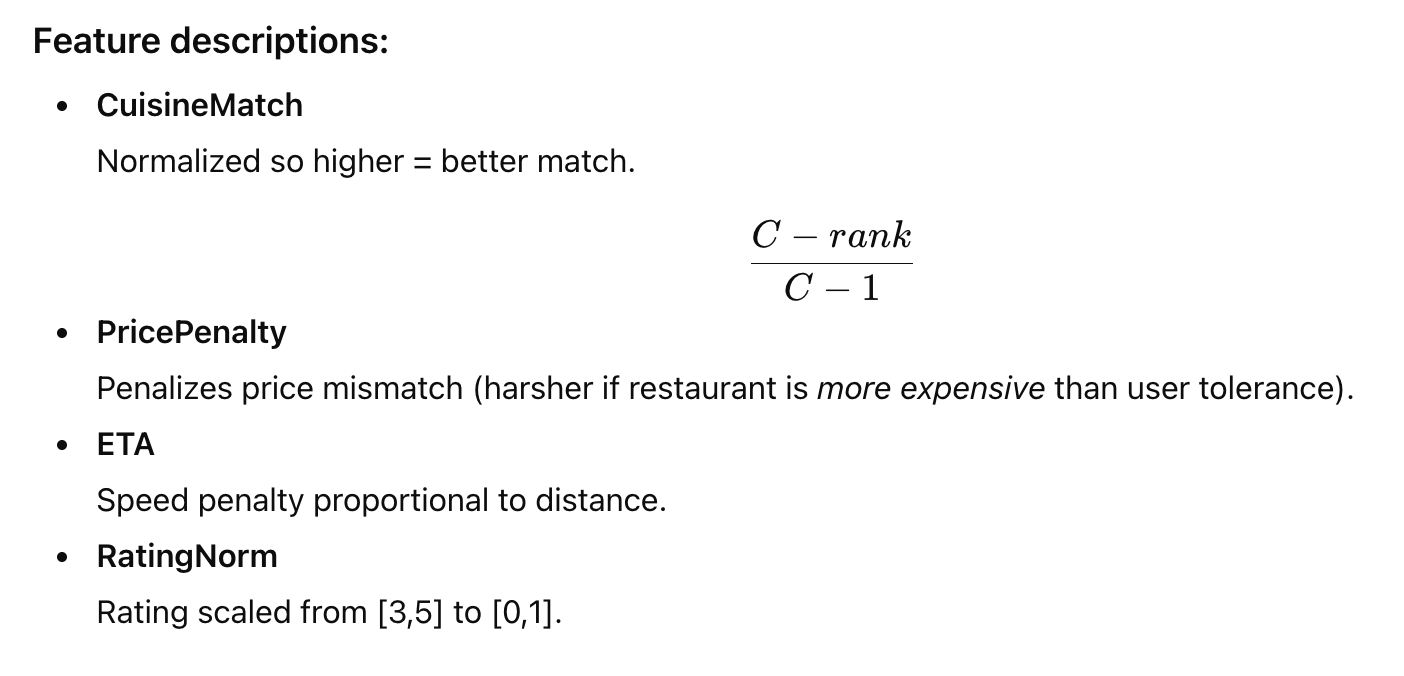

In [ ]:
def cuisine_match(user, rest):
    rank = user["cuisine_rank"].get(rest["cuisine"], len(user["cuisine_rank"]))
    C = len(user["cuisine_rank"])
    return (C - rank) / (C - 1)

def price_penalty(user, rest):
    diff = user["price_tolerance"] - rest["price_level"]
    if diff >= 0:
        return abs(diff) * 0.5  # affordable
    else:
        return abs(diff) * 1.5  # too expensive

def eta(user, rest):
    dist = np.sqrt((user["x"] - rest["x"])**2 + (user["y"] - rest["y"])**2)
    return dist / 10

def rating_norm(r):
    return (r - 3) / 2

# 5. Compute Utility for User–Restaurant Pair


In [ ]:
def compute_utility(user, rest):
    beta = profiles[user["profile"]]["beta"]

    cm  = cuisine_match(user, rest)
    pp  = price_penalty(user, rest)
    rn  = rating_norm(rest["rating_5star"])
    t   = eta(user, rest)

    return beta[0] + beta[1]*cm - beta[2]*pp + beta[3]*rn - beta[4]*t

# 6. Generate One Transaction: Present 5 Restaurants, User Chooses Best

In [ ]:
def simulate_transaction(user):
    # sample offer set
    offer = restaurants.sample(5).copy()
    offer["U"] = offer.apply(lambda r: compute_utility(user, r), axis=1)

    # identify chosen restaurant
    chosen = offer.loc[offer["U"].idxmax()]

    return {
        "user_id": user["user_id"],

        # user features
        "x": user["x"],
        "y": user["y"],
        "profile": user["profile"],
        "profile_name": profiles[user["profile"]]["name"],
        "profile_description": profiles[user["profile"]]["description"],
        "price_tolerance": user["price_tolerance"],
        "cuisine_rank": user["cuisine_rank"],

        # offer set (IDs + names)
        "offer_set_ids": list(offer["restaurant_id"]),
        "offer_set_names": list(offer["name"]),

        # chosen restaurant (ID + name)
        "chosen_id": int(chosen["restaurant_id"]),
        "chosen_name": chosen["name"]
    }


# 7. Generate Full Transaction Log (Ground Truth)

In [ ]:
pd.set_option("display.max_rows", None)
pd.set_option("display.max_columns", None)
pd.set_option("display.width", None)
pd.set_option("display.max_colwidth", None)

transactions = [simulate_transaction(users.iloc[u]) for u in range(len(users))]
gt = pd.DataFrame(transactions)
gt.head()

Groundtruth contains:

| Column              | Description                 |
| ------------------- | --------------------------- |
| user_id             | unique user                 |
| x, y                | user location on 0–10 map   |
| profile             | integer profile (1–10)      |
| profile_name        | readable name               |
| profile_description | behavioral explanation      |
| price_tolerance     | 1,2,3                       |
| cuisine_rank        | JSON dict `{cuisine: rank}` |
| offer_set_ids       | JSON array of ints          |
| offer_set_names     | JSON array of strings       |
| chosen_id           | ID of selected restaurant   |
| chosen_name         | name of selected restaurant |


In [ ]:
gt.to_csv('groundtruth_transaction_data.csv')

In [ ]:
import folium
from folium.plugins import MarkerCluster
import pandas as pd
import ast

# -----------------------------------------------------
# Load datasets
# -----------------------------------------------------
df = pd.read_csv("groundtruth_transaction_data.csv")
restaurants = pd.read_csv("berkeley_real_restaurants_100.csv")

# Convert stringified lists to real lists
df["offer_set_ids"] = df["offer_set_ids"].apply(lambda x: ast.literal_eval(x))

# Choose 5 example users (easier visualization)
sample_users = df.sample(5, random_state=42)

# -----------------------------------------------------
# Create a plain synthetic coordinate map
# -----------------------------------------------------
m = folium.Map(
    location=[5, 5],
    zoom_start=4,
    tiles=None,
    crs="Simple",
    width="100%",
    height="100%"
)

# Add blank background
folium.raster_layers.TileLayer(
    tiles="https://raw.githubusercontent.com/python-visualization/folium/master/examples/data/blank.png",
    attr="Blank",
    name="blank",
    overlay=False,
    control=False
).add_to(m)

# Clusters
rest_cluster = MarkerCluster(name="Restaurants").add_to(m)
user_cluster = MarkerCluster(name="Users").add_to(m)

# -----------------------------------------------------
# Add restaurant markers
# -----------------------------------------------------
restaurant_lookup = restaurants.set_index("restaurant_id")

for _, r in restaurants.iterrows():
    folium.Marker(
        location=[r["y"], r["x"]],
        popup=f"<b>{r['name']}</b><br>{r['cuisine']}<br>Price {r['price_level']}",
        icon=folium.Icon(color="red", icon="cutlery", prefix="fa")
    ).add_to(rest_cluster)

# -----------------------------------------------------
# Draw paths for 5 sample users
# -----------------------------------------------------
for _, row in sample_users.iterrows():

    user_lat, user_lon = row["y"], row["x"]

    # Add user marker
    folium.Marker(
        location=[user_lat, user_lon],
        popup=f"<b>User {row['user_id']}</b><br>Profile: {row['profile_name']}",
        icon=folium.Icon(color="blue", icon="user")
    ).add_to(user_cluster)

    # Draw thin grey lines to each restaurant in offer set
    for rid in row["offer_set_ids"]:
        r = restaurant_lookup.loc[rid]
        folium.PolyLine(
            locations=[[user_lat, user_lon], [r["y"], r["x"]]],
            color="gray",
            weight=2,
            opacity=0.7
        ).add_to(m)

    # Bold colored line to CHOSEN restaurant
    chosen_r = restaurant_lookup.loc[row["chosen_id"]]
    folium.PolyLine(
        locations=[[user_lat, user_lon], [chosen_r["y"], chosen_r["x"]]],
        color="orange",
        weight=6,
        opacity=1
    ).add_to(m)

    # Highlight chosen restaurant
    folium.CircleMarker(
        location=[chosen_r["y"], chosen_r["x"]],
        radius=8,
        color="orange",
        fill=True,
        fill_opacity=0.9,
        popup=f"<b>Chosen: {chosen_r['name']}</b>"
    ).add_to(m)

folium.LayerControl().add_to(m)
m
